In [1]:
import sys
import numpy as np
import copy
%matplotlib nbagg
import matplotlib.pyplot as plt

pulse_building_folder = '/Users/natalie/Documents/PhD/Qdev/QcodesRelated/PulseBuilding'
if pulse_building_folder not in sys.path:
    sys.path.insert(0, pulse_building_folder)

from pulse_building import Waveform, Element, Sequence#, Segment

In [4]:
p_dict = {'sample_rate': 1e9,
          'pulse_end': 2e-6,
          'pulse_readout_delay': 0,
          'marker_readout_delay': 0, 
          'readout_time': 1e-6, 
          'marker_time': 0.6e-6,
          'cycle_duration': 4e-6,
}

### General Variables

In [13]:
waveform.check()

Exception: must specify non None array for wave, marker1, marker2

In [49]:
z

array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.])

In [58]:
[s for s in np.nonzero(z)[0] if z[s-1] != 1][0] - [s for s in np.nonzero(z)[0] if z[s+1] != 1][0]

-1

In [55]:
[s for s in np.nonzero(z)[0] if z[s+1] != 1]

[6]

In [71]:
l

[array([0, 1, 2]), array([0, 1, 2, 3]), array([0, 1, 2, 3, 4]), array([0, 1])]

In [75]:
np.insert(np.array([len(a) for a in l]), 0, 0)

array([0, 3, 4, 5, 2])

In [84]:
starts = [0]
for i, lis in enumerate(l):
    starts.append(len(lis) + starts[i])

In [90]:
np.array(1)

array(1)

<IPython.core.display.Javascript object>


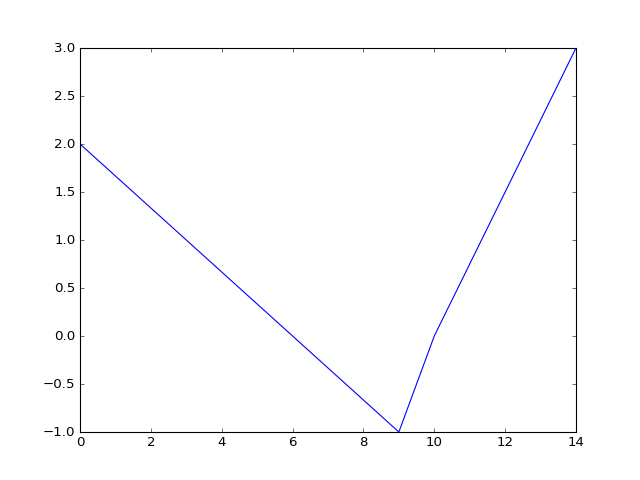

In [12]:
fig = plt.figure()
plt.plot(waveform.wave)

In [52]:
np.concatenate([p.points, q.points])

array([-3.  , -1.75, -0.5 ,  0.75,  2.  , -3.  , -1.75, -0.5 ,  0.75,  2.  ])

In [3]:
def ramp(start, stop, dur, SR):
    points = int(SR * dur)
    return np.linspace(start, stop, points)

In [2]:
cycle_duration = 10e-6
sampling_rate = 5e6
resolution = 1 / sampling_rate
pulse_end = 5e-6
marker_time = 10e-9

total_points = round(cycle_duration / resolution)
pulse_end_points = round(pulse_end / resolution)
marker_points = round(marker_time)

### Readout Settings

In [3]:
pulse_readout_delay = 50e-9
readout_start = pulse_end + pulse_readout_delay
readout_time = 4e-6

readout_start_points = round(readout_start / resolution)
readout_points = round(readout_time / resolution)

readout_waveform = Waveform(length=total_points, channel=2)
readout_waveform.wave[readout_start_points:readout_start_points + readout_points] = 1
readout_waveform.marker_1[pulse_end_points:readout_start_points + marker_points] = 1
readout_waveform.marker_2[pulse_end_points:readout_start_points + marker_points] = 1

## Rabi

In [4]:
rabi_sequence = Sequence(name='rabi',
                         variable='qubit pulse duration',
                         variable_unit='s',
                         step=1e-6,
                         start=0,
                         stop=5e-6)

qubit_duration_array_points = np.round(rabi_sequence.variable_array / resolution).astype(int)

for i, qubit_points in enumerate(qubit_duration_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=total_points, channel=1)
    if i == 0:
        qubit_waveform.marker_1[:marker_points] = 1
        qubit_waveform.marker_2[:marker_points] = 1
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    rabi_sequence.add_element(element)

rabi_sequence.check()
print(len(rabi_sequence.variable_array))

sequence check passed: 6 elements
6


## T1

In [5]:
t1_sequence = Sequence(name='t1',
                       variable='pi pulse readout delay',
                       variable_unit='s',
                       step=0.5e-6,
                       start=0,
                       stop=20e-6)

qubit_time = 1e-6
qubit_points = round(qubit_time / resolution)
delay_array_points = np.round(t1_sequence.variable_array / resolution).astype(np.int)

for i, delay_points in enumerate(delay_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=points, channel=1)
    if i == 0:
        qubit_waveform.marker_1[0:100] = 1
        qubit_waveform.marker_2[0:100] = 1
    qubit_start = pulse_end_points - delay_points - qubit_points
    qubit_end = pulse_end_points - delay_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    t1_sequence.add_element(element)

t1_sequence.check()

NameError: name 'points' is not defined

## SSB

In [8]:
ssb_sequence = Sequence(name='ssb',
                       variable=' diff down from f0',
                       variable_unit='GHz',
                       step=1e6,
                       start=0,
                       stop=200e6)

qubit_time = 1e-6
qubit_points = round(qubit_time / resolution)
qubit_time_array = np.arange(qubit_points) * resolution
freq_array = ssb_sequence.variable_array

for i, freq in enumerate(freq_array):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_i = Waveform(length=points, channel=1)
    qubit_q = Waveform(length=points, channel=2)
    if i == 0:
        qubit_i.marker_1[0:100] = 1
        qubit_i.marker_2[0:100] = 1
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    angle = qubit_time_array * freq * 2 * np.pi
    cos_array = np.cos(angle)
    sin_array = np.sin(angle)
    qubit_i.wave[qubit_start:qubit_end] = cos_array
    qubit_q.wave[qubit_start:qubit_end] = sin_array
    element.add_waveform(qubit_i)
    element.add_waveform(qubit_q)
    ssb_sequence.add_element(element)

ssb_sequence.check()

sequence check passed: 201 elements


True

## Readout SSB

In [9]:
ssb_sequence = Sequence(name='ssb',
                       variable=' diff down from f0',
                       variable_unit='GHz',
                       step=1e6,
                       start=0,
                       stop=100e6)

qubit_time = 1e-6
qubit_points = round(qubit_time / resolution)
qubit_time_array = np.arange(qubit_points) * resolution
freq_array = ssb_sequence.variable_array

for i, freq in enumerate(freq_array):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_i = Waveform(length=points, channel=1)
    qubit_q = Waveform(length=points, channel=2)
    if i == 0:
        qubit_i.marker_1[0:100] = 1
        qubit_waveform.marker_2[0:100] = 1
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    angle = qubit_time_array * freq * 2 * np.pi
    cos_array = np.cos(angle)
    sin_array = np.sin(angle)
    qubit_i.wave[qubit_start:qubit_end] = cos_array
    qubit_q.wave[qubit_start:qubit_end] = sin_array
    element.add_waveform(qubit_i)
    element.add_waveform(qubit_q)
    ssb_sequence.add_element(element)

ssb_sequence.check()

sequence check passed: 101 elements


True

## Plot Sequence

<IPython.core.display.Javascript object>


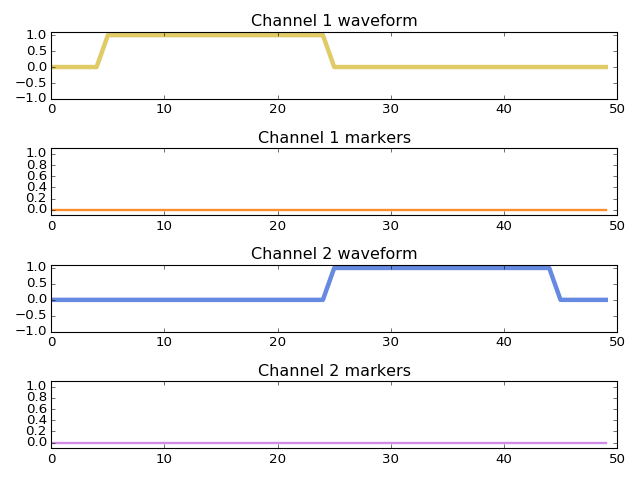

In [5]:
sequence = rabi_sequence # choose which sequence to plot
elemnum = 4 # choose which element to plot
chan_a, chan_b  = 1, 2 # choose which two channels to plot

fig = plt.figure()

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.set_title('Channel {} waveform'.format(chan_a))
ax1.set_ylim([-1, 1.1])
ax2.set_title('Channel {} markers'.format(chan_a))
ax2.set_ylim([-0.1, 1.1])
ax3.set_title('Channel {} waveform'.format(chan_b))
ax3.set_ylim([-1, 1.1])
ax4.set_title('Channel {} markers'.format(chan_b))
ax4.set_ylim([-0.1, 1.1])


ax1.plot(sequence[elemnum][chan_a].wave, lw=4, color='#e1cb66')
ax2.plot(sequence[elemnum][chan_a].marker_1, lw=2, color='#FF4500', alpha=0.6)
ax2.plot(sequence[elemnum][chan_a].marker_2, lw=2, color='#FF8C00', alpha=0.6)

ax3.plot(sequence[elemnum][chan_b].wave, lw=4, color='#6689e1')
ax4.plot(sequence[elemnum][chan_b].marker_1, lw=2, color='#6A5ACD', alpha=0.6)
ax4.plot(sequence[elemnum][chan_b].marker_2, lw=2, color='#EE82EE', alpha=0.6)

plt.tight_layout()

## Upload to AWG

In [6]:
rabi_sequence.unwrap_seq_4dsp()

In [90]:
(waveforms, m1s, m2s ,nreps, trig_waits, goto_states, jump_tos) = ssb_sequence.unwrap()

In [7]:
import qcodes.instrument_drivers.tektronix.AWG5014 as awg
awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.170::inst0::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5014C (serial:B010169, firmware:SCPI:99.0 FW:4.2.0.27) in 0.21s


In [91]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos)

In [92]:
awg1.ch1_state(1)
awg1.ch2_state(1)
awg1.ch3_state(1)
awg1.run()

'Running'